In [6]:
#导入必要的库
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.optimizers import Nadam

# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [7]:
# 设置随机种子
np.random.seed(1234)

# tensorflow V2.x
# For Tensorflow 2.0 tf.random.set_random_seed(seed) changed to tf.random.set_seed(seed).
tf.random.set_seed(1234)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import csv
import os
directory='/content/drive/My Drive/taidi//'
filename='week_sum.csv'
filepath=os.path.join(directory,filename)

In [10]:
# 读取数据
# df = pd.read_csv('./全部数据/order_train1.csv',parse_dates=["order_date"],index_col=[0])   # 把日期变为索引
# df = pd.read_csv('./全部数据/month_sum.csv')   
df = pd.read_csv(filepath)   # 读取存在google drive的文件


# df = df.drop(columns = ['sales_chan_name','item_price'])  # 先删除price列，因为predict_sku0没有price特征，后面可看看利用price

first_col = df.pop('ord_qty')
df.insert(1, 'ord_qty', first_col)  #把订单量变为第一列

display(df)  
df.info()

,order_date,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
0,2015-9-1,54,20007,101,305,412,2015,9,36,98.000000,28,0,0.00
1,2015-9-1,18,20020,101,305,412,2015,9,36,1918.000000,28,0,0.00
2,2015-9-1,39,20082,101,305,412,2015,9,36,1161.500000,28,0,0.00
3,2015-9-1,388,20092,101,306,407,2015,9,36,731.000000,36,0,0.00
4,2015-9-1,66,20096,101,306,407,2015,9,36,950.000000,36,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
154332,2018-12-1,85,22058,105,302,408,2018,12,51,1379.571429,24,76,69.25
154333,2018-12-1,7,22059,105,305,412,2018,12,51,453.000000,28,27,35.25
154334,2018-12-1,618,22066,105,307,403,2018,12,51,336.000000,41,102,928.00
154335,2018-12-1,248,22072,105,305,412,2018,12,51,427.000000,28,657,460.50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154337 entries, 0 to 154336
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   order_date         154337 non-null  object 
 1   ord_qty            154337 non-null  int64  
 2   item_code          154337 non-null  int64  
 3   sales_region_code  154337 non-null  int64  
 4   first_cate_code    154337 non-null  int64  
 5   second_cate_code   154337 non-null  int64  
 6   year               154337 non-null  int64  
 7   month              154337 non-null  int64  
 8   week               154337 non-null  int64  
 9   item_price         154337 non-null  float64
 10  brand_qty_median   154337 non-null  int64  
 11  lag_4              154337 non-null  int64  
 12  rmean_4_4          154337 non-null  float64
dtypes: float64(2), int64(10), object(1)
memory usage: 15.3+ MB


In [11]:
testset_start = df[(df.year==2018)&(df.month==9)].index.tolist()[0]
testset_end = df[(df.year==2018)&(df.month==11)].index.tolist()[-1]
print(testset_start, testset_end)

133506 150288


In [12]:
#设置LSTM的时间窗等参数
window = 60  # 60 3 30 300
lstm_units = 200  # 100 200
dropout = 0.01  
epoch=100  # 最大epoch, 会早停
batch_size = 280  # 128 280 480
activation='tanh'

In [13]:
# #进行数据归一化
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()
# df0=min_max_scaler.fit_transform(df1)
# df = pd.DataFrame(df0, columns=df1.columns)
# input_size=len(df.iloc[1,:])  # 特征数量

In [14]:
# 拆分训练/验证集, 验证集为2018.9 - 2018.11数据， 训练集为验证集之前的数据
# X_train = df.iloc[0:testset_start-1,2:].values
# Y_train = df.iloc[0:testset_start-1,0].values
# X_test = df.iloc[testset_start:testset_end,2:].values
# Y_test = df.iloc[testset_start:testset_end,0].values
# # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False, random_state=33)  # 暂不打乱数据集
# input_size= X_train.shape[1]  # 特征数量

df_for_training=df.iloc[0:testset_start-1,1:]
df_for_testing=df.iloc[testset_start:testset_end,1:]
input_size= df_for_training.shape[1]  # 特征数量


In [15]:
print(df_for_training.shape)
print(df_for_testing.shape)
print(input_size)

(133505, 12)
(16782, 12)
12


In [16]:
display(df_for_training)
display(df_for_testing)

,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
0,54,20007,101,305,412,2015,9,36,98.000000,28,0,0.00
1,18,20020,101,305,412,2015,9,36,1918.000000,28,0,0.00
2,39,20082,101,305,412,2015,9,36,1161.500000,28,0,0.00
3,388,20092,101,306,407,2015,9,36,731.000000,36,0,0.00
4,66,20096,101,306,407,2015,9,36,950.000000,36,0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
133500,8,22045,105,302,408,2018,8,35,1660.000000,24,4,73.00
133501,4,22048,105,306,407,2018,8,35,777.000000,36,5,22.25
133502,599,22056,105,302,408,2018,8,35,661.500000,24,46,180.00
133503,31,22058,105,302,408,2018,8,35,1403.333333,24,36,91.25


,ord_qty,item_code,sales_region_code,first_cate_code,second_cate_code,year,month,week,item_price,brand_qty_median,lag_4,rmean_4_4
133506,19,20018,101,306,407,2018,9,35,1476.666667,36,367,392.00
133507,36,20131,101,306,407,2018,9,35,973.500000,36,254,386.25
133508,20,20134,101,305,412,2018,9,35,1029.333333,28,48,48.75
133509,116,20152,101,305,412,2018,9,35,207.000000,28,31,406.00
133510,5,20162,101,302,408,2018,9,35,1241.000000,24,165,59.75
...,...,...,...,...,...,...,...,...,...,...,...,...
150283,16,22046,105,305,412,2018,11,48,1335.000000,28,201,142.25
150284,6,22052,105,302,408,2018,11,48,2760.000000,24,10,5.75
150285,169,22058,105,302,408,2018,11,48,1398.750000,24,87,104.50
150286,1205,22066,105,307,403,2018,11,48,324.750000,41,6912,2555.50


In [17]:
# # 拆分训练/测试集
# train_size = int(len(df) * 0.9)
# # test_size = len(df) - train_size
# df_for_training=df[0:train_size]
# df_for_testing=df[train_size:len(df)]

# input_size=len(df.iloc[1,:])  # 特征数量

# print(df_for_training.shape)
# print(df_for_testing.shape)

In [18]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 数据标准化
scaler = MinMaxScaler(feature_range=(0,1))
df_for_training_scaled = scaler.fit_transform(df_for_training)
df_for_testing_scaled=scaler.transform(df_for_testing)

In [35]:
display(df_for_testing_scaled)

array([[6.00020001e-04, 8.16130581e-03, 0.00000000e+00, ...,
        7.39130435e-01, 1.22333333e-02, 2.54590917e-02],
       [1.16670556e-03, 6.24099856e-02, 0.00000000e+00, ...,
        7.39130435e-01, 8.46666667e-03, 2.50856484e-02],
       [6.33354445e-04, 6.38502160e-02, 0.00000000e+00, ...,
        3.91304348e-01, 1.60000000e-03, 3.16614980e-03],
       ...,
       [5.60018667e-03, 9.87518003e-01, 1.00000000e+00, ...,
        2.17391304e-01, 2.90000000e-03, 6.78692624e-03],
       [4.01346712e-02, 9.91358617e-01, 1.00000000e+00, ...,
        9.56521739e-01, 2.30400000e-01, 1.65971196e-01],
       [2.18673956e-02, 9.94239078e-01, 1.00000000e+00, ...,
        3.91304348e-01, 7.66666667e-04, 1.48565491e-02]])

In [19]:
# 分X,Y
# def createXY(dataset, time_step=1):
# 	dataX, dataY = [], []
# 	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
# 		a = dataset[i:(i+window), 0:dataset.shape[1]]   
# 		dataX.append(a)
# 		dataY.append(dataset[i + window, 0]) #第一列为订单量
# 	return np.array(dataX), np.array(dataY)

def createXY(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-window-1):  # Time Series setps (0-99,100-200,,,,) any steps
		a = dataset[i:(i+window), 0:dataset.shape[1]]   
		dataX.append(a)
		dataY.append(dataset[i + window, 0]) #第一列为订单量
	return np.array(dataX), np.array(dataY)

time_step = window
trainX,trainY=createXY(df_for_training_scaled,window)
testX,testY=createXY(df_for_testing_scaled,window)

In [36]:
display(testY)

array([0.00023334, 0.00070002, 0.00763359, ..., 0.00016667, 0.00560019,
       0.04013467])

In [20]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)
print(trainX.shape[2])

(133444, 60, 12)
(133444,)
(16721, 60, 12)
(16721,)
12


In [21]:
# model = Sequential()

# # 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入20时间步，10个特征

# model.add(Bidirectional(LSTM(12, return_sequences=True), input_shape=(20, 10)))

# model.add(Dropout(0.1))

# # 最后一层LSTM,return_sequences=False

# model.add(Bidirectional(LSTM(12, return_sequences=False)))

# model.add(Dropout(0.1))

# # 重点是这里的5*3的设置

# model.add(Dense(5 * 3))

# model.add(Dropout(0.1))

# # 输出5个时间步长，3个特征

# model.add(Reshape((5, 3)))

In [22]:
#建立LSTM模型 训练

# 优化器
my_adam = Adam(learning_rate=0.001)
my_nadam = Nadam(learning_rate = 0.001)


inputs=Input(shape=(window, input_size))
# model=Conv1D(filters = lstm_units, kernel_size = 1, activation = 'sigmoid')(inputs)#卷积层
# model=MaxPooling1D(pool_size = window)(model)#池化层
# model=Dropout(dropout)(model)#droupout层
# 第一层LSTM，12是单元个数超参数，多层LSTM前面几层必须return_sequences=True，输入window个时间步，input_size个特征
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=True), name='bilstm')(inputs)#双向LSTM层
model=Dropout(dropout)(model)#droupout层
# 最后一层LSTM,return_sequences=False
model=Bidirectional(LSTM(lstm_units, activation=activation, return_sequences=False),name='bilstm2')(model)
model=Dropout(dropout)(model)#droupout层
# attention=Dense(lstm_units, activation='sigmoid', name='attention_vec')(model)#求解Attention权重
# model=Multiply()([model, attention])#attention与LSTM对应数值相乘
outputs = Dense(1, activation='tanh')(model)
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='mse',optimizer=my_nadam)

model.summary()


# model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
# model.compile(loss='mse',optimizer=my_nadam)
# my_model.summary()#展示模型结构

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 12)]          0         
                                                                 
 bilstm (Bidirectional)      (None, 60, 400)           340800    
                                                                 
 dropout (Dropout)           (None, 60, 400)           0         
                                                                 
 bilstm2 (Bidirectional)     (None, 400)               961600    
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 1,302,801
Trainable params: 1,302,801
Non-train

In [23]:
# use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
        verbose=1, mode='auto', restore_best_weights=True)

# 模型训练
history=model.fit(trainX, trainY, epochs = epoch, batch_size = batch_size, shuffle=False,callbacks=[monitor], validation_data=(testX, testY)) #训练模型epoch次

Epoch 1/100
477/477 [==============================] - 43s 68ms/step - loss: 0.0028 - val_loss: 7.9839e-04
Epoch 2/100
477/477 [==============================] - 32s 68ms/step - loss: 8.8832e-04 - val_loss: 8.0045e-04
Epoch 3/100
477/477 [==============================] - 33s 69ms/step - loss: 8.7665e-04 - val_loss: 7.9828e-04
Epoch 4/100
477/477 [==============================] - 33s 69ms/step - loss: 8.6302e-04 - val_loss: 7.9718e-04
Epoch 5/100
477/477 [==============================] - 33s 69ms/step - loss: 8.5756e-04 - val_loss: 7.9847e-04
Epoch 6/100
477/477 [==============================] - 33s 69ms/step - loss: 8.5373e-04 - val_loss: 7.9752e-04
Epoch 7/100
477/477 [==============================] - 33s 68ms/step - loss: 8.5098e-04 - val_loss: 7.9777e-04
Epoch 8/100
477/477 [==============================] - 33s 68ms/step - loss: 8.4913e-04 - val_loss: 7.9843e-04
Epoch 9/100
477/477 [==============================] - 33s 69ms/step - loss: 8.4753e-04 - val_loss: 7.9932e-04
Epoch

In [24]:
# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import GridSearchCV
# # grid_model=KerasRegressor(build_fn=build_model,verbose=1,validation_data=(testX,testY))
# grid_model=KerasRegressor(build_fn=my_model,verbose=1,validation_data=(testX,testY))
# parameters = {'batch_size' : [128,576],
#         'epochs' : [25],
#         # 'optimizer' : ['adam'] 
#         'dropout': [0.002],
#         'optimizer' : [my_nadam],
#         'lstm_units': [50, 100, 200],
#         'activation': ['tanh','relu'] }

# grid_search  = GridSearchCV(estimator = grid_model,
#                 param_grid = parameters, n_jobs=-1,
#                 cv = 2)

In [25]:
# # # use early stop to avoid over-fiting  早停法防止过拟合,若loss不减小，训练停止
# # from tensorflow.keras.callbacks import EarlyStopping
# # monitor = EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=20, 
# #         verbose=1, mode='auto', restore_best_weights=True)

# # grid_search = grid_search.fit(trainX,trainY, epochs = epoch, callbacks=[monitor])
# grid_search = grid_search.fit(trainX,trainY )


In [26]:
# grid_search.best_params_

In [27]:
# model = grid_search.best_estimator_.model
# model.summary()  # 展示模型结构

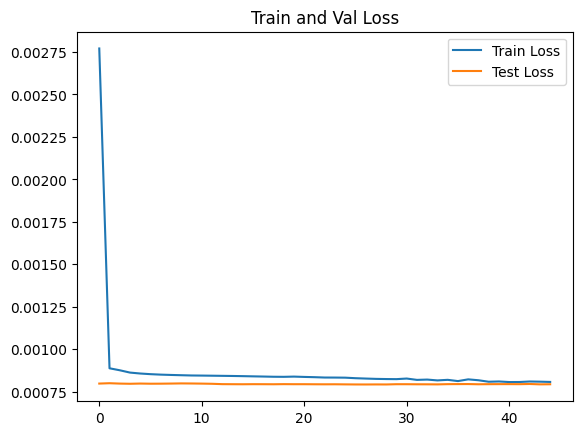

In [28]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
# loss = model.history['loss']
# val_loss = model.history['val_loss']
# epochs_range = range(epoch)
epochs_range = range(len(loss))
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Test Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

523/523 [==============================] - 5s 7ms/step
(16721, 1)


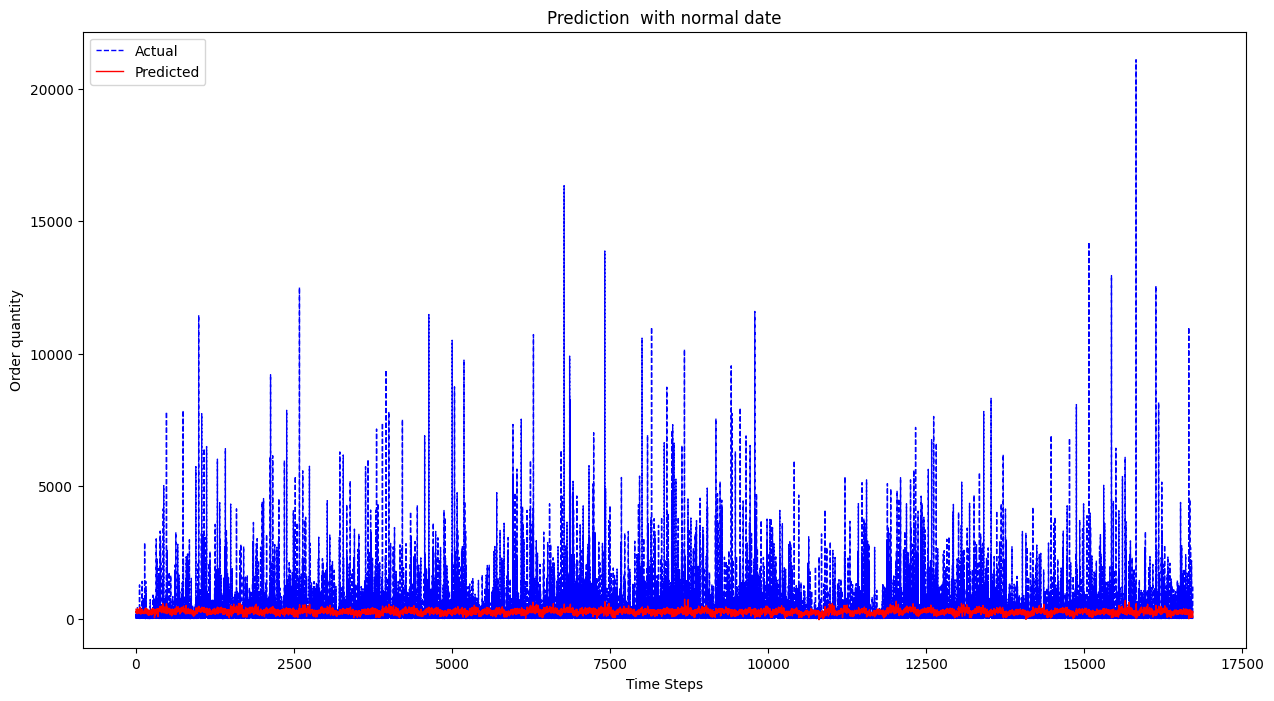

In [29]:
# 还原模型预测

# create the list of difference between prediction and test data
predictions = model.predict(testX)
print(predictions.shape)

# 反归一化
prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(testY_inv,color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(predictions_inv,color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [41]:

df_test_copy = df_for_testing.iloc[0:-window-1,:]
df_test_copy.insert(loc=0, column='ord_qty_pre', value = predictions_inv)
df_test_copy = df_test_copy.groupby(['year','month','sales_region_code', 'item_code', 'first_cate_code','second_cate_code'],as_index=False).agg({'ord_qty': 'sum', 'ord_qty_pre':'sum'})
display(df_test_copy)


,year,month,sales_region_code,item_code,first_cate_code,second_cate_code,ord_qty,ord_qty_pre
0,2018,9,101,20002,303,406,45,684.204468
1,2018,9,101,20003,301,405,93,753.614502
2,2018,9,101,20006,307,403,109,591.833496
3,2018,9,101,20014,307,403,16,675.168152
4,2018,9,101,20016,303,401,930,1029.219360
...,...,...,...,...,...,...,...,...
5762,2018,11,105,22059,305,412,37,476.080627
5763,2018,11,105,22066,307,403,9330,702.004272
5764,2018,11,105,22072,305,412,1185,727.551758
5765,2018,11,105,22081,303,401,15,450.196655


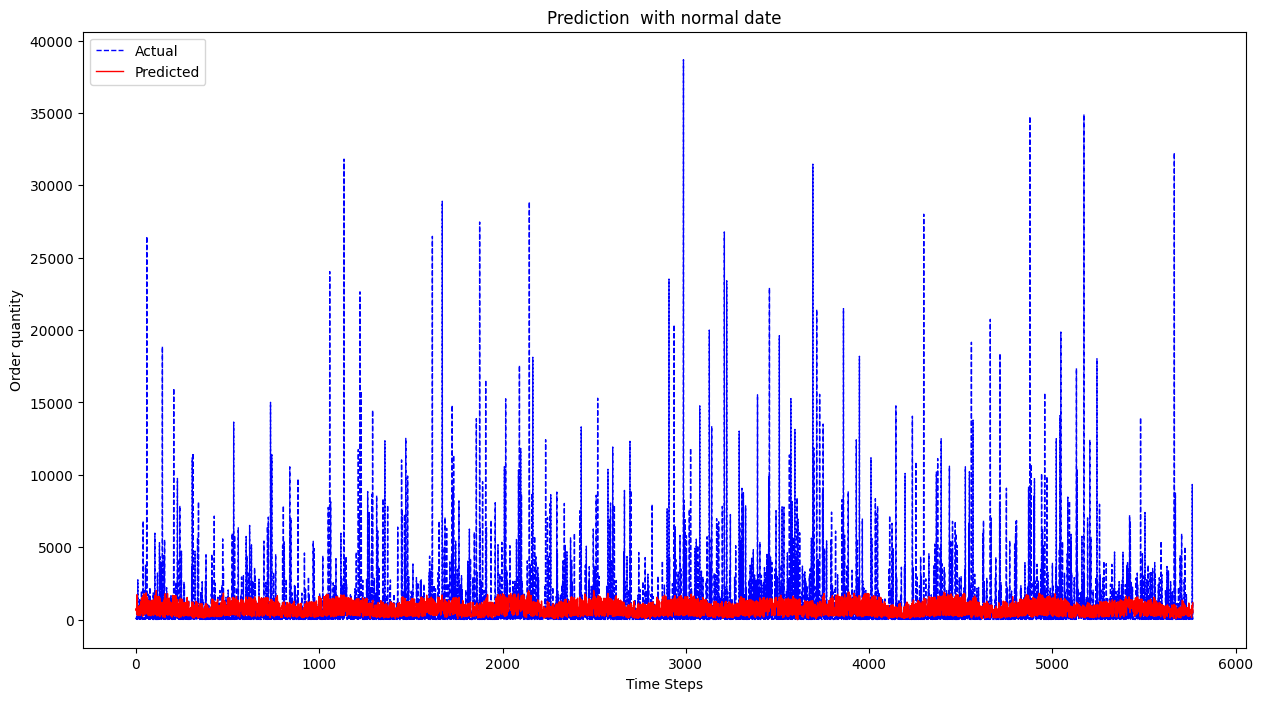

In [42]:
# 还原模型预测

# # create the list of difference between prediction and test data
# predictions = model.predict(testX)
# print(predictions.shape)

# # 反归一化
# prediction_copies_array = np.repeat(predictions,testX.shape[2], axis=-1)
# predictions_inv=scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predictions),testX.shape[2])))[:,0]

# testY_copies_array = np.repeat(testY,testX.shape[2], axis=-1)
# testY_inv=scaler.inverse_transform(np.reshape(testY_copies_array,(len(testY),testX.shape[2])))[:,0]

# Showing the predicted vs. actual values
fig, axs = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(15)

axs.plot(df_test_copy['ord_qty'],color='blue', label='Actual',linestyle='--',linewidth=1)
axs.plot(df_test_copy['ord_qty_pre'],color='red', label='Predicted',linewidth=1)
# axs.scatter(outliers.index,outliers, color='green', linewidth=5.0, label='Anomalies')
plt.title('Prediction  with normal date')
plt.xlabel('Time Steps')
plt.ylabel('Order quantity')
plt.legend(loc='upper left')
plt.show()


In [43]:
# 使用sklearn调用衡量模型的MSE 、 RMSE、 MAE、r2
print('------------验证集-周-------------')
print("mae:", mean_absolute_error(testY_inv, predictions_inv))
print("mape:", mean_absolute_percentage_error(testY_inv, predictions_inv))
print("mse:", mean_squared_error(testY_inv, predictions_inv))
print("rmse:", sqrt(mean_squared_error(testY_inv, predictions_inv)))
print("r2:", r2_score(testY_inv, predictions_inv))

print('------------验证集-月-------------')
print("mae:", mean_absolute_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mape:", mean_absolute_percentage_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("mse:", mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))
print("rmse:", sqrt(mean_squared_error(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre'])))
print("r2:", r2_score(df_test_copy['ord_qty'], df_test_copy['ord_qty_pre']))

------------验证集-周-------------
mae: 372.8435600873892
mape: 12.712119317690554
mse: 714222.3189596463
rmse: 845.1167487156116
r2: -0.0019811046661921683
------------验证集-月-------------
mae: 982.4733069717357
mape: 14.070296283505325
mse: 6283374.641792578
rmse: 2506.666041137626
r2: 0.07963551249632006
